This is the repository for the "Quantum transformer for High Energy Physics Analysis at the LHC", a Google Summer of Code 2023 project by ML4Sci instution QMLHeP group. The purpose of the project is to have a proof-of-concept Quantum Vision Transformer implementation for the jet data classification.

It is not possible to implement a QViT using this code yet as the project is still in progress. However this repo will be updated weekly to show the progress.

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pennylane
    !git clone https://github.com/EyupBunlu/QViT_HEP_ML4Sci

<a target="_blank" href="https://colab.research.google.com/github/EyupBunlu/QViT_HEP_ML4Sci">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import seaborn as sns
import math
from tqdm.notebook import tqdm
import time
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

if IN_COLAB: from QViT_HEP_ML4Sci.QViT import *
else: from QViT import *

torch.set_default_dtype(torch.float64)
torch.set_num_threads(8)
device='cpu'

## First Method

The first method to achieve our goal will be reproducing the architecture in the paper ["Quantum Vision Transformers"](https://arxiv.org/pdf/2209.08167.pdf) (referred as QViT paper in the file) if possible.

Papers of interest

Conference Paper: https://indico.jlab.org/event/459/contributions/11832/ \
Beamsplitter Decomposition Paper: https://arxiv.org/pdf/2212.07389.pdf \
Beamsplitter Qumode Explanation: https://quantumcomputing.stackexchange.com/questions/32286/how-to-represent-beam-splitter-and-kerr-gates-as-basic-quantum-logic-gates\ \
QViT Paper: https://arxiv.org/pdf/2209.08167.pdf \

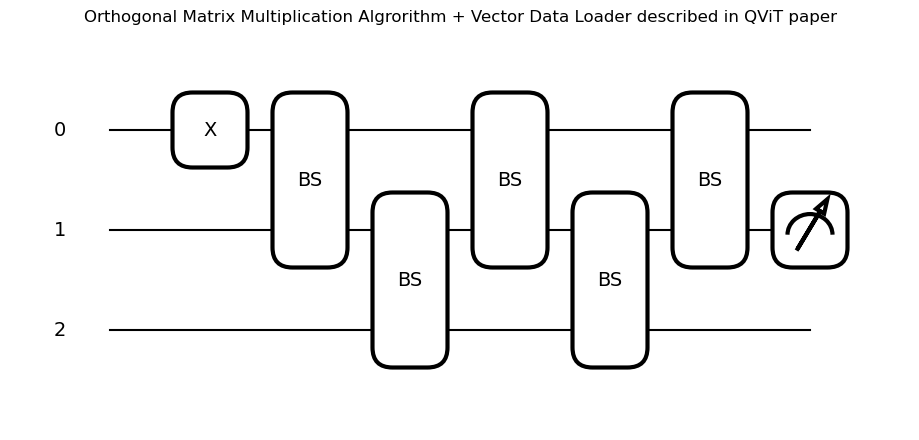

In [3]:
length = 3
qml.draw_mpl(mmult_bs,show_all_wires=True,wire_order=[i for i in range(length)])(torch.zeros(10),torch.ones(2))
q=plt.title('Orthogonal Matrix Multiplication Algrorithm + Vector Data Loader described in QViT paper')

The Beamsplitter gate mentioned in the paper only works with the qumodes. However it can be decomposed as the following combination of gates as explained in the paper
["Quantum Methods for Neural Networks and Application to Medical Image Classification"](https://arxiv.org/pdf/2212.07389.pdf)

Text(0.5, 1.0, 'BeamSplitter Equivalent Structure')

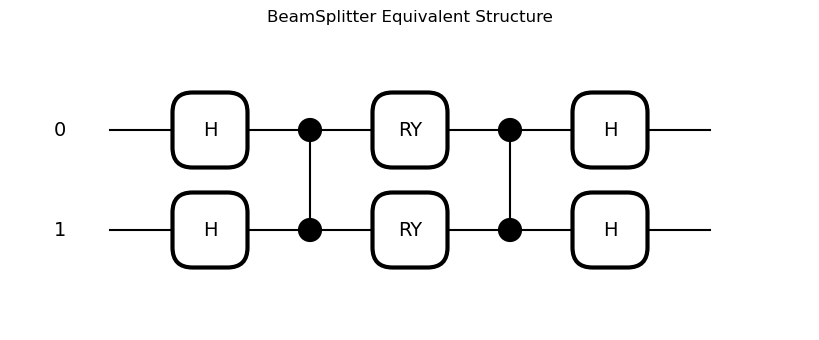

In [4]:
qml.draw_mpl(rbs,show_all_wires=True)([0,1],torch.tensor([0]))
plt.title('BeamSplitter Equivalent Structure')

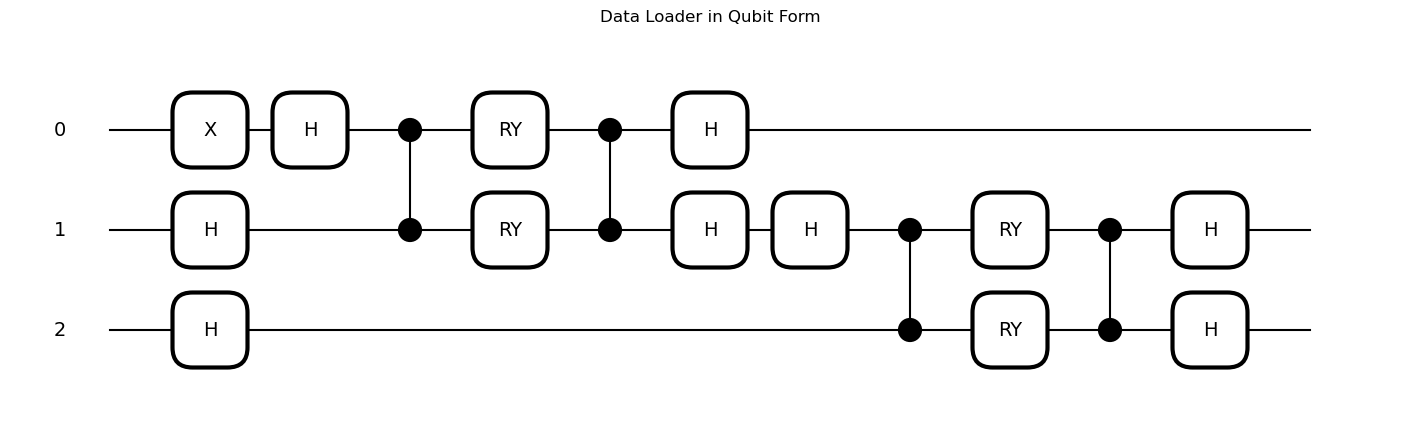

In [5]:
qml.draw_mpl(vector_loader,show_all_wires=True,wire_order=[i for i in range(3)])(torch.ones(2))
q=plt.title('Data Loader in Qubit Form')

Suggested data loader takes n-1 parameters to load length n data.
Data loader circuit can be expressed as the following.

$$\Psi = \left[\Sigma_{i=0}^{n-2} \left(\Pi^{i-1}_{j=0}\sin \alpha_j \right)e_i \cos \alpha_i \right]+\left(\Pi^{n-1}_{j=0}\sin \alpha_j \right)e_{n-1}$$.
Therefore, one can load normalized vector $x_i$ using the following parameters:
$$\alpha_0 = cos^{-1}(x_0)$$
$$\alpha_i = cos^{-1}\left(x_i / \left[1-\Sigma_{j=0}^{i-1}x_j^2\right]^{-1/2}\right)$$


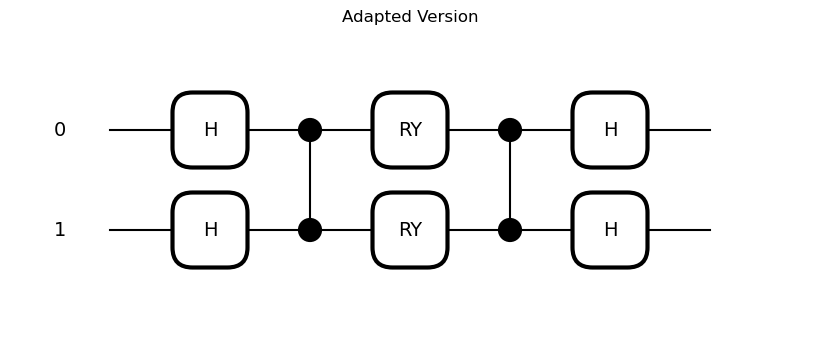

In [6]:
qml.draw_mpl(mmult,show_all_wires=False,wire_order=[i for i in range(length)])(torch.zeros(10),None,2)
q=plt.title('Adapted Version')

### Vector Loader Demonstration

In [7]:
X = torch.tensor([1/2,1/2,1/np.sqrt(2)],requires_grad=False)
alphas = convert_array(X)
wires = [ str(i) for i in range (X.shape[0])]

Loading X: [0.5        0.5        0.70710678]


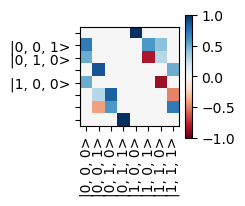

In [9]:
plot_opm(vector_loader,[alphas,wires],wire_order = None)
print('Loading X: {}'.format(X.numpy()))

### Matrix Loader Demonstration

Matrix loader used in the QViT paper consists of multiple vector loaders and some CNOT gates. In order to load a matrix of nxd, one needs to use n+1 many data loaders and n+d qubits. It encodes the data to the qubits as,
$$|\Psi>=\sum_{i,j}^{n,d} \frac{X_{ij}}{||X||} |m_i> \otimes |e_j> $$
where $|m_i>$ are magnitude qubits and $|e_j>$ are vector qubits.

In [10]:
X = torch.tensor([[1,1,1],[0,1,0],[0,0,1]],requires_grad=False)
nrow,ncolumn = X.shape
mag_wires = [ '||X||_'+str(i) for i in range (nrow)]
wires = [ str(i) for i in range (ncolumn)]

mag_alphas,alphas = convert_matrix(X)

In [11]:
mag_alphas

tensor([0.6847, 0.7854])

Data Loader


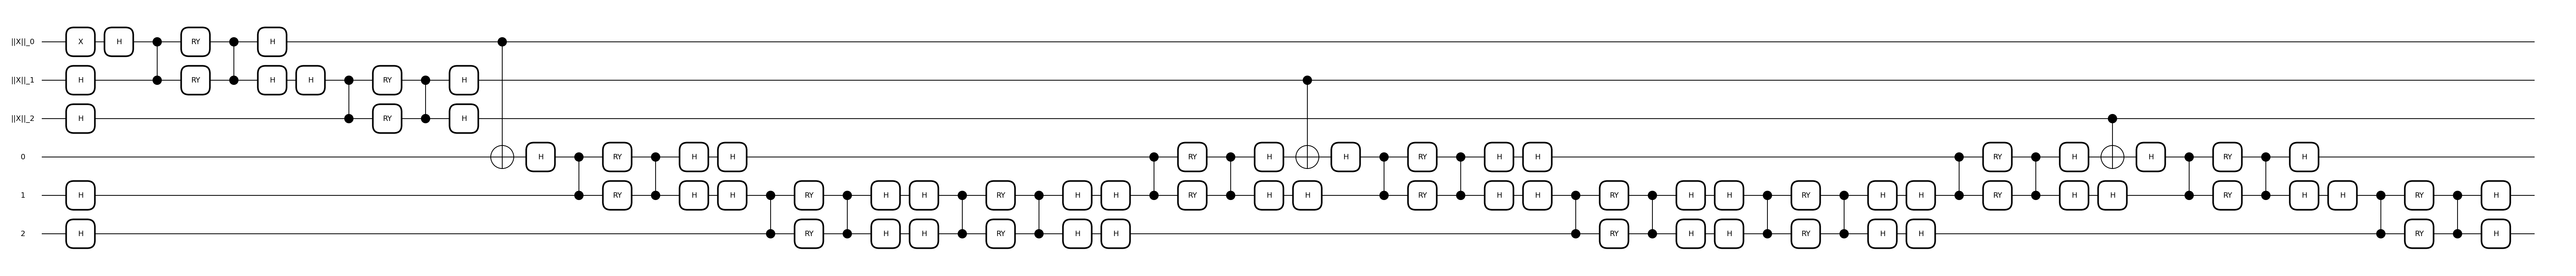

In [12]:
qml.draw_mpl(matrix_loader,show_all_wires=True,wire_order=mag_wires+wires)(mag_alphas,alphas,mag_wires,wires)
# q=plt.title('$\huge{Circuit Form}$')
print('Data Loader')

Text(0.5, 1.0, "Matrix Loader's Matrix Representation for Loading \n X=[[1 1 1]\n [0 1 0]\n [0 0 1]]")

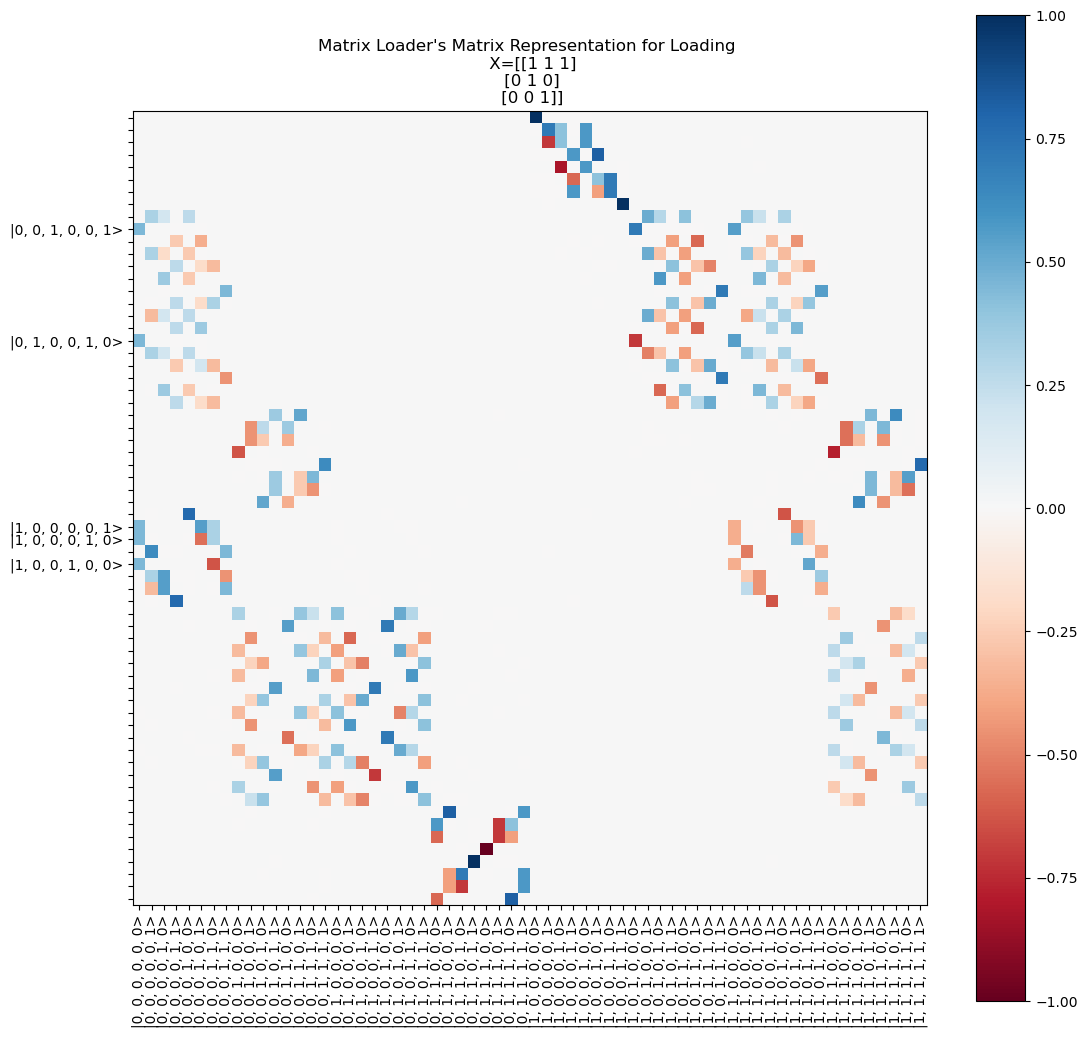

In [13]:
plot_opm(matrix_loader,(mag_alphas,alphas,mag_wires,wires),wire_order = mag_wires+wires)
plt.title('Matrix Loader\'s Matrix Representation for Loading \n X={}'.format(X.numpy()))

### Demonstration of $A_{ij}=x_i^TWx_j$ calculation

In order to calculate the $A_{ij}=x_i^TWx_j$, one needs to load the $|x_j>$ then apply W then load $<x_i|$. \
In order to achieve this we will need d many qubits where our data is a $nxd$ matrix.\
We need to make sure that we multiply our output with the norms of $x_i$ and $x_j$ since our data loader only takes unit normalized vectors as input. \
For this demonstration, A random orthogonal matrix is created and the loss function is set such that it is minimum if W is that matrix. In addition, I took the absolute value of Y as this method doesn't retrieve the sign.

In [17]:
torch.manual_seed(0)
X = torch.rand(5,2,2)
n = X.shape[1]+1
d = X.shape[2]
n_epoch = 100

In [18]:
W_ideal = torch.rand(d,d)
W_ideal = W_ideal-W_ideal.T
W_ideal = (torch.eye(d)-W_ideal)@(torch.eye(d)+W_ideal).inverse()

Y = torch.einsum('nik,kl,njl->nij',X,W_ideal,X)

alphas = convert_array(X)
norms = (X**2).sum(axis=-1).sqrt()
wires=[i for i in range(d)]

In [19]:


loss_fn = lambda yhat,y :((yhat-y)**2).sum(axis=[-1,-2]).sqrt().mean()
bar = tqdm(range(n_epoch))
QLayer = circuit_to_layer(compute_attention_element,wires,{'phi':(n**2-n)//2})
optim=torch.optim.Adam(QLayer.parameters(),lr=5e-2)

for i in bar:
    yhat = []
    optim.zero_grad()
    yhat = compute_attention(alphas,norms,QLayer)
    loss_ = loss_fn(yhat,Y)
    bar.set_postfix_str(loss_.item())
    loss_.backward()
    optim.step()



  0%|          | 0/100 [00:00<?, ?it/s]

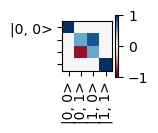

In [24]:
plot_opm(mmult,(next(QLayer.parameters()),wires))

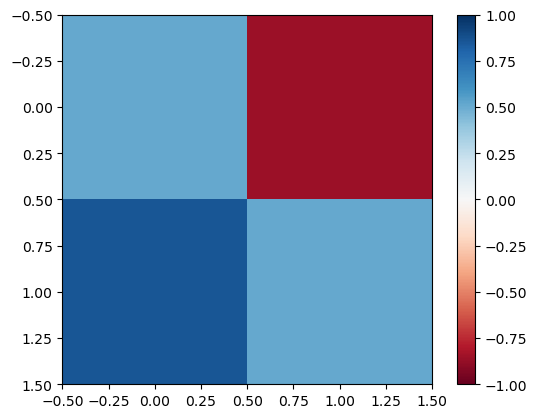

In [25]:
plt.imshow(W_ideal,vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar()

### Matrix Multiplication on X Demonstration

It would be possible to start creating a transformer once we can perform orthogonal matrix multiplication on the loaded data vector and retrieve the signs. This part will be added later for completeness but it wouldn't be used as it demands too many qubits.

$\textbf{Soon to be Added}$

### Hybrid Transformer

A hybrid transformer structure is implemented below. It is almost identical to a classic ViT except
$$\text{Softmax}\left( \frac{(W_KX) (W_QX)^T)}{\sqrt n}\right)$$
calculation is replaced with
$$\text{Softmax}\left( \frac{QC(W,X)}{\sqrt n}\right)$$
where X (bxnxd) is the input.

This approach requires retrieving expectation value of the first qubit for $n^2$ many times where the circuit has d qubit. Therefore quantum part of this circuit would have $O(n^2f(d))$ where f(d) is the time required for the circuit to retrieve the expectation value.
On the other hand, using a classical method to perform the same operation would have time complexity of $O(nd^2+n^2d)$.

The experimental calculation of f(d) is shown below



Text(0, 0.5, 'f(d) in seconds')

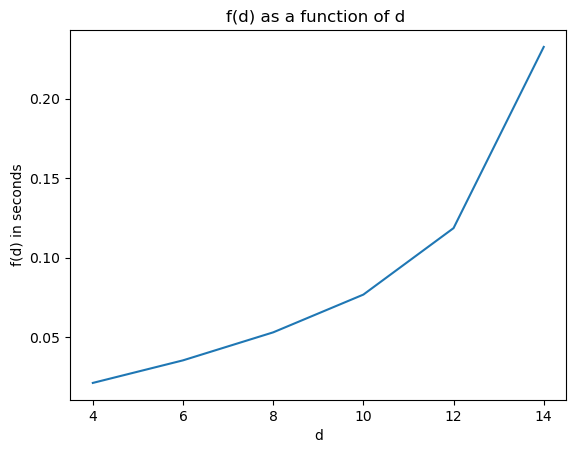

In [38]:
t={}
l=[]
n=10
for i in range(4,16,2):
    X=convert_array(torch.rand(2,i))
    A = circuit_to_layer(compute_attention_element,wires=list(range(i)),pars={'phi':2*i-3})
    t_ = time.time()
    for _ in range(n):A(X.flatten())
    t[i]= (time.time()-t_)/n
    l.append(i)

plt.plot(t.keys(),[t[i] for i in t.keys()])
plt.title("f(d) as a function of d ")
plt.xlabel('d')
plt.ylabel('f(d) in seconds')

In [39]:
t

{4: 0.021120262145996094,
 6: 0.03532869815826416,
 8: 0.052949142456054685,
 10: 0.07671148777008056,
 12: 0.11854870319366455,
 14: 0.23259172439575196}

This is a big problem given we will need to perform this operation for $n_{\text{heads}}n_{\text{layers}}n_{\text{epoch}}bn^2$ many times. If we wanted to implement this model for MNIST classification with 14 patches of 14 length arrays, two layers with two heads and 200 data points, an epoch would take 72128 seconds or 20 hours on CPU, not including classical parts. \

Therefore, a way to reduce the time required is necessary.



An implementation for MNIST can be found below

In [43]:
mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 14,14
device = 'cpu'
transform = transforms.Compose([
    transforms.Resize((14,14)),
transforms.ConvertImageDtype(torch.float64),transforms.Lambda(lambda x: x.reshape(-1,n,d)/255) ])
mnist_trainset = simple_dataset(transform(mnist_trainset.data).to(device),mnist_trainset.targets.to(device))

tr_set,val_set,rest = torch.utils.data.random_split(mnist_trainset,[200,40,mnist_trainset.target.shape[0]-240])
tr_dl = DataLoader(tr_set,batch_size=1)
val_dl = DataLoader(val_set,batch_size=1)



In [44]:
model = HViT(n,d,n_layers=1,n_h=1,FC_layers=[16,16,10],is_hybrid=True).to(device)

/home/e_/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [45]:
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 20
loss = 0
bar_epoch = tqdm(range(n_epochs))
loss_fn = nn.CrossEntropyLoss()
for epoch in bar_epoch:
    loss =0
    total_samples = 0
    bar_batch = tqdm(tr_dl)
    for i in bar_batch:
        optim.zero_grad()
        yhat = model(i['input'])
        y = i['output']
        loss_ = loss_fn(yhat,y)
        loss_.sum().backward()
        loss += loss_.sum().item()
        optim.step()
        total_samples += y.shape[0]
        bar_batch.set_postfix_str(f'loss:{loss/total_samples}')

    bar_epoch.set_postfix_str(f'loss:{loss/total_samples}')



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Second Method

Papers of interest:\
https://arxiv.org/abs/2205.05625

This approach is more computation friendly

Text(0.5, 1.0, 'KEY/QUERY Ansatz and dataloading')

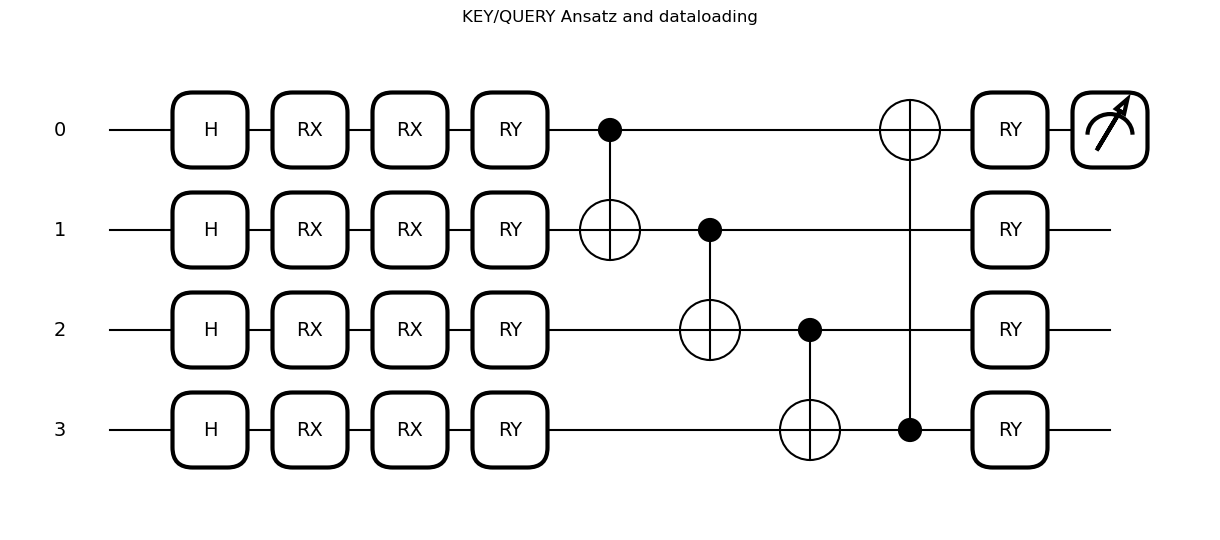

In [4]:
n_wires= 4
wires = list(range(n_wires))
phi = torch.rand(n_wires,4).flatten()
data = torch.rand(3,n_wires)
qml.draw_mpl(measure_query_key,wire_order=(list(range(n_wires))))(data,phi)
plt.title('KEY/QUERY Ansatz and dataloading')

In [5]:

# class MultiHead(nn.Module):
#     def __init__(self,d_t,d_k,n_h,is_hybrid):
#         super(MultiHead,self).__init__()
#         if is_hybrid:
#             self.heads =  nn.ModuleList(AttentionHead_Hybrid(d_t,d_k) for i in range(n_h))
#         else:
#             self.heads =  nn.ModuleList(AttentionHead(d_t,d_k) for i in range(n_h))

#         self.merger = nn.Linear(n_h,1)

#     def forward(self,input1):
#         res = torch.empty(*input1.shape,len(self.heads),device = self.merger.weight.device)
#         for i,m in enumerate(self.heads):
#             res[...,i] =m(input1)
#         return self.merger(res).squeeze(-1)


# class Transformer(nn.Module):
#     def __init__(self,d_t,d_k,n_h,n_layers,is_hybrid):
#         super(Transformer,self).__init__()
#         self.embedder = nn.LazyLinear(d_k)
#         self.pos_embedding = torch.tensor([ [math.sin(i/1000**((j-1))/d_k) ] if i%2==1 else [math.cos(i/1000**((j-1))/d_k)] for i in range(d_t) for j in range(d_k)  ])
#         self.attention_layers = nn.ModuleList( MultiHead(d_t+1,d_k,n_h,is_hybrid) for i in range(n_layers))
#         self.class_token = nn.parameter.Parameter(torch.normal(torch.zeros(d_k),1/d_k))
#         self.norm = nn.LayerNorm(d_k)
#     def forward(self,input1):



#         input1_ = torch.cat( (self.class_token.broadcast_to([input1.shape[0],1,self.class_token.shape[0]]), self.embedder(input1)),axis=1)
#         + self.pos_embedding[None,:,:]
#         input1__ = self.norm(input1_)

#         temp = []
#         for i,m in enumerate(self.attention_layers):
#             if i!=0: temp.append(m(temp[-1]))
#             else: temp.append(m(input1__))

#         return temp[-1][:,-1,:]


# class HViT(nn.Module):
#     def __init__(self,d_t,d_k,n_h,n_layers,FC_layers,is_hybrid):
#         super(HViT,self).__init__()
#         self.transformer = Transformer(d_t,d_k,n_h,n_layers,is_hybrid)
#         self.classifier = construct_FNN(FC_layers)
#     def forward(self,input1):

#         return self.classifier(self.transformer(input1))


# def construct_FNN(layers,activation=nn.ReLU,output_activation=None,Dropout = None):
#     layer = [j for i in layers for j in [nn.LazyLinear(i),activation()] ][:-1]
#     if Dropout:
#         layer.insert(len(layer)-2,nn.Dropout(Dropout))
#     if output_activation is not None:
#         layer.append(output_activation)
#     return nn.Sequential(*layer)

In [6]:
mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 14,14

transform = transforms.Compose([
    transforms.Resize((14,14)),
transforms.ConvertImageDtype(torch.float64),transforms.Lambda(lambda x: x.reshape(-1,n,d)/255) ])
mnist_trainset = simple_dataset(transform(mnist_trainset.data).to(device),mnist_trainset.targets.to(device))

tr_set,val_set,rest = torch.utils.data.random_split(mnist_trainset,[200,40,mnist_trainset.target.shape[0]-240])
tr_dl = DataLoader(tr_set,batch_size=16)
val_dl = DataLoader(val_set,batch_size=16)



In [7]:
model = HViT(n,d,n_layers=2,n_h=2,FC_layers=[16,16,10],attention_type='hybrid2').to(device)

/home/e_/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 20
loss = 0
bar_epoch = tqdm(range(n_epochs))
loss_fn = nn.CrossEntropyLoss()
for epoch in bar_epoch:
    loss =0
    total_samples = 0
    bar_batch = tqdm(tr_dl)
    for i in bar_batch:
        optim.zero_grad()
        yhat = model(i['input'])
        y = i['output']
        loss_ = loss_fn(yhat,y)
        loss_.sum().backward()
        loss += loss_.sum().item()
        optim.step()
        total_samples += y.shape[0]
        bar_batch.set_postfix_str(f'loss:{loss/total_samples}')

    bar_epoch.set_postfix_str(f'loss:{loss/total_samples}')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Future Goal's

Goal's Achieved from 25/05 to 07/06:

- Implementing Beam splitter equivalent for a Qubit circuit.\
- How to parametrize data for the circuit\
- Loading a vector\
- Applying a matrix multiplication on a loaded vector.\
- Training the mentioned matrix.

Goal's Achieved from 07/06 to 14/06:\
- Loading a data matrix
- Cleaning the code
- Documentation and tidying up the github repo

Goal's Achieved from 14/06 to 21/06:\
- Busy week, no progress.

Goal's Achieved from 21/06 to 05/07:\
- Calculating $|<x_j|A|x_i>|$ using quantum circuits
- Implementing a hybrid vision transformer, (A)

Future goals for the next week:\
- Implementing of $Vx_i$
- Training the mentioned hybrid transformer on a basic mnist dataset.
- Exploring the pennylane for a possible speed-up
  
Future Goals
- Look for alternative ways for a QViT